In [1]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

from pydantic import BaseModel, Field
from typing import  Literal
from langchain_core.tools import tool
from langgraph.graph import MessagesState,StateGraph, END

from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

In [2]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [3]:
tavily_tool = TavilySearchResults(max_results=5)

In [4]:
class CityDetails(BaseModel):
    """Respond to the user with this"""
    state_name: str = Field(description="State name of the city")
    state_capital: str = Field(description="State capital of the city")
    country_name: str = Field(description="Country name of the city")
    country_capital: str = Field(description="Country capital of the city")

In [5]:
# Inherit 'messages' key from MessagesState, which is a list of chat messages
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: CityDetails

In [6]:
@tool
def get_city_details(prompt):
    "Should do a web search to find the required city details"
    response = tavily_tool.invoke(prompt)
    return response

In [7]:
tools = [get_city_details]

In [8]:
model_with_tools = llm.bind_tools(tools)
model_with_structured_output = llm.with_structured_output(CityDetails)

In [37]:
def call_model(state: AgentState):
    print(f"here is {state}")
    response = model_with_tools.invoke(state['messages'])
    print(f"this is respond {response}")
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [38]:
def respond(state: AgentState):
    print(f"here is one more {state}")
    response = model_with_structured_output.invoke([HumanMessage(content=state['messages'][-2].content)])
    # We return the final answer
    print(f"this is one more respond {response}")
    return {"final_response": response}

In [39]:
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue
    else:
        return "continue"

In [40]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

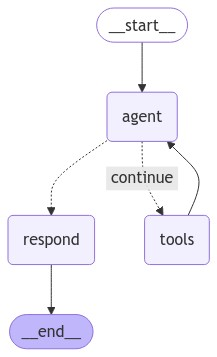

In [41]:
from IPython.display import Image, display
# View
display(Image(graph.get_graph().draw_mermaid_png()))

here is {'messages': [HumanMessage(content='Tell me about the city details for patna?', additional_kwargs={}, response_metadata={}, id='0a312ade-37cf-43c8-8e26-c7083bdad7d7')]}

In [42]:

answer = graph.invoke(input={"messages": [("human", "Tell me about the city details for patna?")]})['final_response']


here is {'messages': [HumanMessage(content='Tell me about the city details for patna?', additional_kwargs={}, response_metadata={}, id='f365ebea-8e33-4459-a538-f39848bb53e5')]}
this is respond content='' additional_kwargs={'tool_calls': [{'id': 'call_54w9', 'function': {'arguments': '{"prompt":"patna"}', 'name': 'get_city_details'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 945, 'total_tokens': 1030, 'completion_time': 0.154545455, 'prompt_time': 0.03021448, 'queue_time': 0.0029498970000000034, 'total_time': 0.184759935}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-d94c5189-3632-4473-8e19-16c8b4dff7c3-0' tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'patna'}, 'id': 'call_54w9', 'type': 'tool_call'}] usage_metadata={'input_tokens': 945, 'output_tokens': 85, 'total_tokens': 1030}
here is {'messages': [HumanMessage(content='Tell me about 

: 

In [35]:
answer

CityDetails(state_name='Madhya Pradesh', state_capital='Bhopal', country_name='India', country_capital='New Delhi')